In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from model.model import SiameseNN
from model.config import config
from model.processing.data_management import load_data, prepare_data, prepare_dataloader, train_generator, test_generator

Using TensorFlow backend.


In [2]:
data = load_data()

C:\Users\skyst\Documents\ProfessionalDevelopment\DataSciencePortfolio\facialRecognition\packages\model\model\data\subject*


In [3]:
train_images, train_labels, test_images, test_labels = prepare_data(data)

In [4]:
train_positives, train_negatives, test_positives, test_negatives = prepare_dataloader(train_images, train_labels, test_images, test_labels)

In [5]:
model = SiameseNN(config.FEATURE_DIM)

In [6]:
model.load_state_dict( state_dict = torch.load(config.TRAINED_MODEL_DIR / config.MODEL_NAME) )

<All keys matched successfully>

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
model.to(device)

cuda:0


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [8]:
len(train_positives)

428

In [9]:
len(test_positives)

45

In [10]:
# Convenience function to make predictions
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [11]:
# calculate accuracy before training
# since the dataset is imbalanced, we'll report tp, tn, fp, fn
def get_train_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = config.BATCH_SIZE
  x_batch_1 = np.zeros((batch_size, 1, config.H, config.W))
  x_batch_2 = np.zeros((batch_size, 1, config.H, config.W))
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  for i in range(n_batches):
    pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    neg_batch_indices = train_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(tp + fn)
  print(tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

In [12]:
def get_test_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = config.BATCH_SIZE
  x_batch_1 = np.zeros((batch_size, 1, config.H, config.W))
  x_batch_2 = np.zeros((batch_size, 1,config.H, config.W))
  n_batches = int(np.ceil(len(test_positives) / batch_size))
  for i in range(n_batches):
    pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = test_images[idx1]
      x_batch_2[j,0] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(test_negatives) / batch_size))
  for i in range(n_batches):
    neg_batch_indices = test_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()


  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(tp + fn)
  print(tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

428
13664
sensitivity (tpr): 1.0, specificity (tnr): 0.9716042154566745


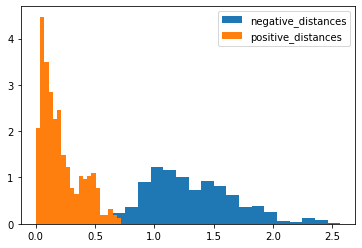

In [13]:
get_train_accuracy(0.7402)

45
1890
sensitivity (tpr): 1.0, specificity (tnr): 0.9851851851851852


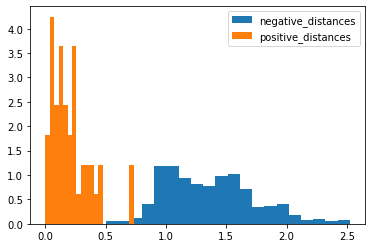

In [14]:
get_test_accuracy(0.7402)